# Exploring thermal behaviour

Thomas Schanzer  
January 2022

In this notebook, we test the behaviour of our scheme's ascending and descending thermals in different soundings and with different initial conditions.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import pandas as pd
from scipy.interpolate import interp1d
import sys

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT

from dparcel.environment import idealised_sounding
sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator

## Soundings

We use soundings from Williamtown NSW at 0 UTC (1100 AEDT) on 21 December 2021 and Changi Airport, Singapore at 0 UTC (0800 UTC+8) on 1 December 2021, which both have fairly large CAPE.

Our scheme struggles with sounding data with irregular pressure level spacing, so we interpolate the data to a uniform spacing of 5 mbar.

In [2]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
sounding = pd.read_fwf(
    file, names=['p_wtown', 'z_wtown', 't_wtown', 'td_wtown'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[::-1,0]
height = sounding[::-1,1]
temperature = sounding[::-1,2]
dewpoint = sounding[::-1,3]

p_wtown = np.arange(pressure[0], pressure[-1], 5)*units.mbar
z_wtown = interp1d(pressure, height)(p_wtown)*units.meter
t_wtown = interp1d(pressure, temperature)(p_wtown)*units.celsius
td_wtown = interp1d(pressure, dewpoint)(p_wtown)*units.celsius
q_wtown = mpcalc.specific_humidity_from_dewpoint(p_wtown, td_wtown)
wtown = ThermalGenerator(
    p_wtown, z_wtown, t_wtown, q_wtown)

file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(
    file, names=['p_sgp', 'z_sgp', 't_sgp', 'td_sgp'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[::-1,0]
height = sounding[::-1,1]
temperature = sounding[::-1,2]
dewpoint = sounding[::-1,3]

p_sgp = np.arange(pressure[0], pressure[-1], 5)*units.mbar
z_sgp = interp1d(pressure, height)(p_sgp)*units.meter
t_sgp = interp1d(pressure, temperature)(p_sgp)*units.celsius
td_sgp = interp1d(pressure, dewpoint)(p_sgp)*units.celsius
q_sgp = mpcalc.specific_humidity_from_dewpoint(p_sgp, td_sgp)
sgp = ThermalGenerator(p_sgp, z_sgp, t_sgp, q_sgp)

In [3]:
profile_wtown = mpcalc.parcel_profile(p_wtown[::-1], t_wtown[-1], td_wtown[-1])
cape_wtown, cin_wtown = mpcalc.cape_cin(
    p_wtown[::-1], t_wtown[::-1], td_wtown[::-1], profile_wtown)

profile_sgp = mpcalc.parcel_profile(p_sgp[::-1], t_sgp[-1], td_sgp[-1])
cape_sgp, cin_sgp = mpcalc.cape_cin(
    p_sgp[::-1], t_sgp[::-1], td_sgp[::-1], profile_sgp)

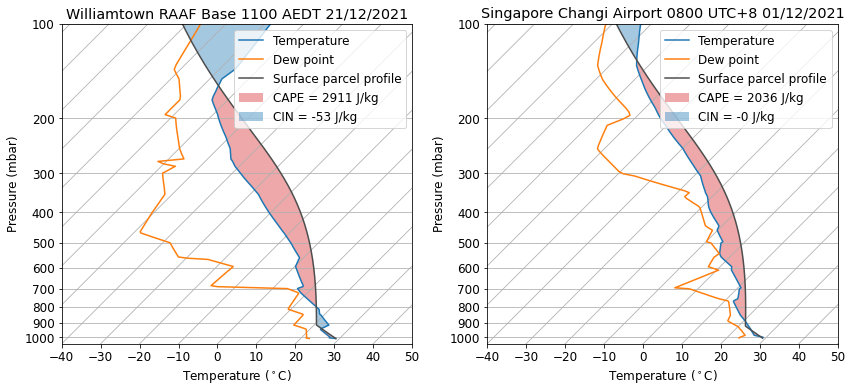

In [111]:
fig = plt.figure(figsize=(12,6))

skew = SkewT(fig, rotation=45, subplot=(1,2,1))
skew.plot(p_wtown, t_wtown, label='Temperature')
skew.plot(p_wtown, td_wtown, label='Dew point')
skew.plot(p_wtown, profile_wtown[::-1], '0.3', label='Surface parcel profile')
skew.shade_cape(p_wtown, t_wtown, profile_wtown[::-1],
                label='CAPE = {:.0f} J/kg'.format(cape_wtown.m))
skew.shade_cin(p_wtown, t_wtown, profile_wtown[::-1],
                label='CIN = {:.0f} J/kg'.format(cin_wtown.m))
skew.ax.legend(loc='upper right')
skew.ax.set(xlabel='Temperature ($^\circ$C)', ylabel='Pressure (mbar)',
            title='Williamtown RAAF Base 1100 AEDT 21/12/2021')

skew = SkewT(fig, rotation=45, subplot=(1,2,2))
skew.plot(p_sgp, t_sgp, label='Temperature')
skew.plot(p_sgp, td_sgp, label='Dew point')
skew.plot(p_sgp, profile_sgp[::-1], '0.3', label='Surface parcel profile')
skew.shade_cape(p_sgp, t_sgp, profile_sgp[::-1],
                label='CAPE = {:.0f} J/kg'.format(cape_sgp.m))
skew.shade_cin(p_sgp, t_sgp, profile_sgp[::-1],
                label='CIN = {:.0f} J/kg'.format(cin_sgp.m))
skew.ax.legend(loc='upper right')
skew.ax.set(xlabel='Temperature ($^\circ$C)', ylabel='Pressure (mbar)',
            title='Singapore Changi Airport 0800 UTC+8 01/12/2021')

fig.tight_layout()

## Updrafts

In [108]:
%%time
z_init = np.arange(0, 2.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
t_pert = np.arange(0.3, 3.1, 0.3)*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.5/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 1e-3*units.dimensionless

updrafts_wtown = np.empty((z_init.size, t_pert.size), dtype='object')
updrafts_sgp = np.empty((z_init.size, t_pert.size), dtype='object')
n_done = 0
n_tot = z_init.size*t_pert.size*2
for i in range(z_init.size):
    for j in range(t_pert.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_wtown[i,j] = wtown.updraft(
            i_init_wtown[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, drag, l_crit)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_sgp[i,j] = sgp.updraft(
            i_init_sgp[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, drag, l_crit)
sys.stdout.write('\n')

Calculation 100 of 100     
CPU times: user 31.5 s, sys: 128 ms, total: 31.6 s
Wall time: 31.6 s


1

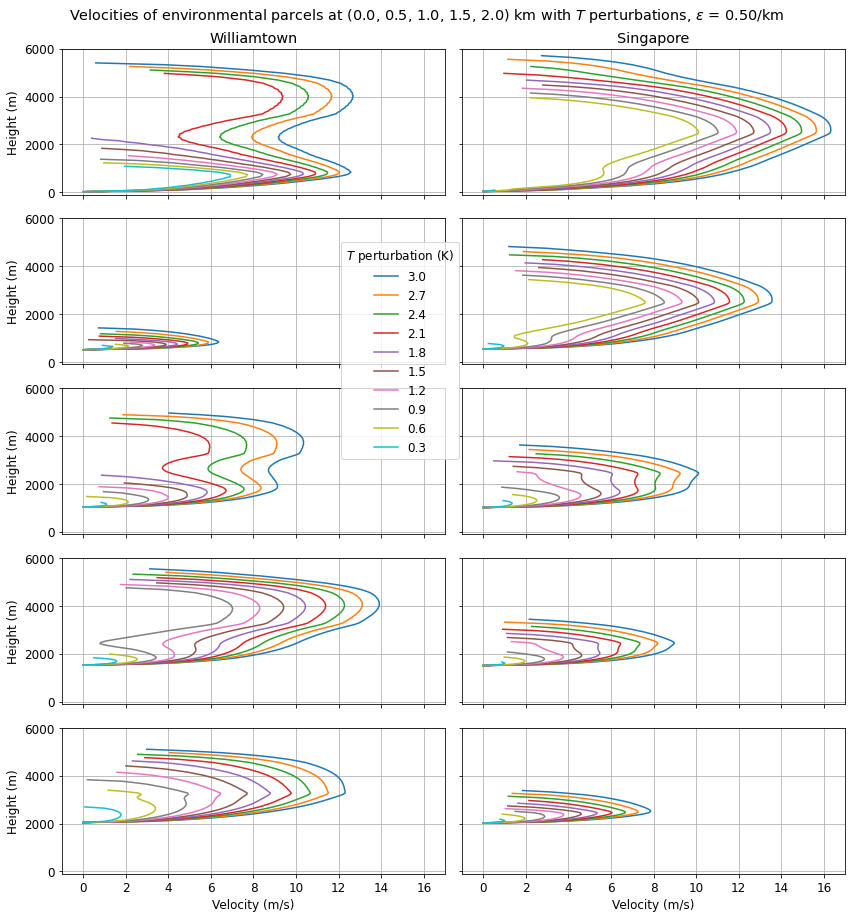

In [113]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(t_pert.size - 1, -1, -1):
        axes[i,0].plot(updrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(updrafts_sgp[i,j].velocity, z_sgp, label='{:.1f}'.format(t_pert[j].m))
for ax in axes.ravel():
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-1, 17)
    ax.set_ylim(-100, 6000)
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.4, 0.5))
lgd.set_title('$T$ perturbation (K)')
fig.suptitle(
    'Velocities of environmental parcels at (0.0, 0.5, 1.0, 1.5, 2.0) km '
    'with $T$ perturbations, $\epsilon$ = {:.2f}/km'.format(rate.m))
fig.tight_layout()